In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In this part, we will make some basic insights into the dataset.
First, let's see the structure of dataset. There are 20491 hotel reviews together with ratings (scale from 1 to 5) that were given along with the reviews. Most of them are reviews with ratings "4" and "5".

In [4]:
raw = pd.read_csv('../tripadvisor_hotel_reviews.csv')
df = raw.copy()
raw.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [140]:
raw.shape

(20491, 2)

Rating
1    0.069348
2    0.087502
3    0.106583
4    0.294715
5    0.441853
Name: Rating, dtype: float64


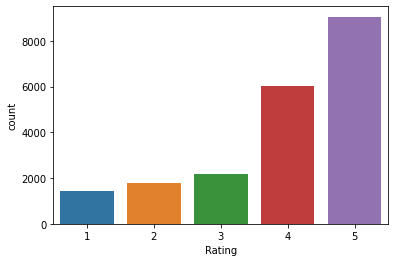

In [141]:
print(raw.groupby('Rating')['Rating'].count()/raw.shape[0])
sns.countplot(x='Rating', data=raw)
plt.show()

After preprocessing let's see the reviews' length (number of words). Most reviews (96%) are shorter than 300 words, the mean length is 101. There are many outliers - 2393.

In [6]:
df['Review_length'] = df['Review'].map(lambda x: len(x.split()))
print(f'Number of outliers: {df[df.Review_length > 1.5 * df.Review_length.quantile(0.75)].shape[0]}')

Number of outliers: 2398


Basic stats of Review lengths
 count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Review_length, dtype: float64


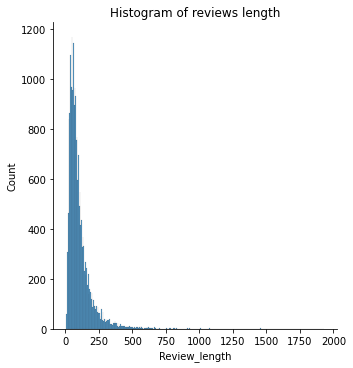

In [143]:
sns.displot(df['Review_length'])
print('Basic stats of Review lengths\n',df['Review_length'].describe())
plt.title('Histogram of reviews length')
plt.show()

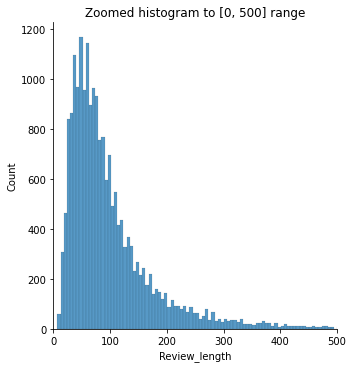

In [144]:
sns.displot(df['Review_length']).set(xlim=[0,500])
plt.title('Zoomed histogram to [0, 500] range')
plt.show()

In [9]:
x=df.groupby(df.Review_length < 250)['Review_length'].count()
print(x)
print(x[1]/(x.sum()))

Review_length
False     1276
True     19215
Name: Review_length, dtype: int64
0.9377287589673515


 


Let's check distributions of reviews lengths regarding `Rating` level. Lower ratings have much havier tails than the higher ones. Furthermore, distributions of lower-rated reviews are slightly shifted to the larger values. Among reviews with more than 300 words, ratings are more equally distributed.

In [146]:
df.groupby('Rating')['Review_length'].agg([np.mean, np.median])

,mean,median
Rating,,
1,112.365236,82
2,126.601227,95
3,114.705586,86
4,107.771651,78
5,93.963773,69


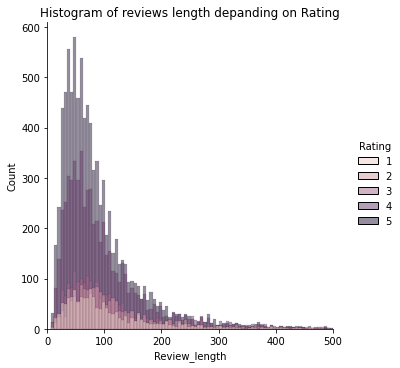

In [147]:
sns.displot(data=df, x='Review_length', hue='Rating').set(xlim=[0,500])
plt.title('Histogram of reviews length depanding on Rating')
plt.show()

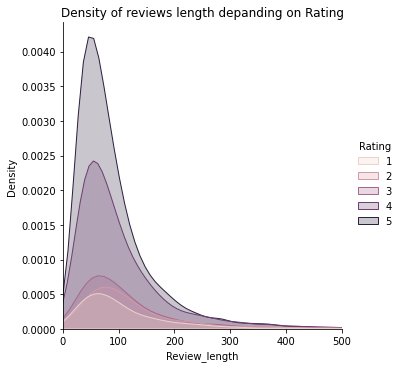

In [148]:
# denstity plot for better view of differences
sns.displot(df, x="Review_length", hue="Rating", kind="kde", fill=True).set(xlim=[0,500])
plt.title('Density of reviews length depanding on Rating')
plt.show()

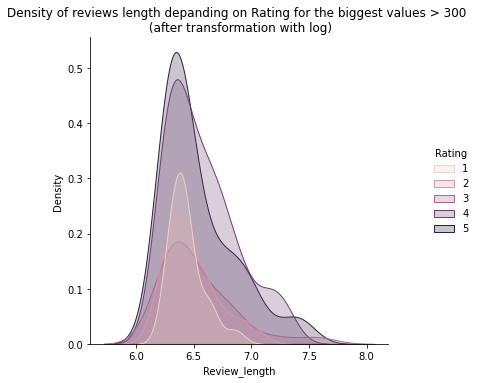

In [149]:
# distribution of the longest reviews, scaled with log
sns.displot(x=np.log(df.loc[df.Review_length>500, 'Review_length']),
            hue=df.loc[df.Review_length>500, 'Rating'], kind='kde', fill=True)
plt.title('Density of reviews length depanding on Rating for the biggest values > 300 \n (after transformation with log)')
plt.show()

## Structure of reviews
Let's see how review texts are structured regarding the sentiment of text in particular parts of review. Do medium-critical reviews praise for some elements of stay at the beginning or start from describing negative thoughts? How do start the lowest-rated reviews?

To answer this, we will use a pre-trained sentiment analyzer VADER. Before that, we tokenize and prune review length to 300 words. The best option would be to split of text according to sentences, but since there are no punctuation marks in our data set, we divide text every 4 words and analyze their sentiment. VADER returns four values: `pos` - positive sentiment with values[0,1], `neg` - negative sentiment with values [0,1], `neu` - neutral sentiment with values [0,1] and `compound` - aggregated score indicating positive or negative sentiment with values [-1,1].

In [150]:
df = raw.copy()

In [151]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
MAX_LENGTH = 300
CHUNK_SIZE = 4
MAX_CHUNK_NUMBER = int(300/CHUNK_SIZE)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pawel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [152]:
def review_into_sentiment_chunks(row):
    tokenized_text = row['Review'].split()[:MAX_LENGTH]
    text_chunks = [' '.join(tokenized_text[i:i+CHUNK_SIZE]) for i in range(0, len(tokenized_text), CHUNK_SIZE)]

    polarity_scores = [analyzer.polarity_scores(x) for x in text_chunks]
    
    for feature in ['neg', 'pos', 'compound']:
        pad_vector = np.zeros(MAX_CHUNK_NUMBER)
        polarities_of_chunks = np.array([x[feature] for x in polarity_scores])
        polarities_of_chunks = polarities_of_chunks.repeat(int(MAX_CHUNK_NUMBER/len(polarities_of_chunks)))
        pad_vector[:polarities_of_chunks.shape[0]] += polarities_of_chunks
        row['sentiment_chunks_'+feature] = pad_vector
    
    return row
analyzer = SentimentIntensityAnalyzer()
df = df.apply(review_into_sentiment_chunks, axis=1)

After applying the function above we created columns with sentiment values vectors (each vector has a length of 75, one value for each chunk). Sentiment vectors shorter than 300 words are stretched to 300 for the ability to compare localization of sentiments across the review.

In [153]:
df.head()

,Review,Rating,sentiment_chunks_neg,sentiment_chunks_pos,sentiment_chunks_compound
0,nice hotel expensive parking got good deal sta...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.483, 0.483, 0.483, 0.492, 0.492, 0.492, 0.0...","[0.4215, 0.4215, 0.4215, 0.4404, 0.4404, 0.440..."
1,ok nothing special charge diamond member hilto...,2,"[0.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.341, 0.444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[-0.015, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
2,nice rooms not 4* experience hotel monaco seat...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.423, 0.524, 0...","[0.483, 0.0, 0.492, 0.0, 0.524, 0.0, 0.0, 0.0,...","[0.4215, 0.0, 0.4404, 0.0, 0.5106, 0.0, -0.296..."
3,"unique, great stay, wonderful time hotel monac...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.796, 0.796, 0.796, 0.0, 0.0, 0.0, 0.552, 0....","[0.8316, 0.8316, 0.8316, 0.0, 0.0, 0.0, 0.5719..."
4,"great stay great stay, went seahawk game aweso...",5,"[0.0, 0.0, 0.0, 0.323, 0.0, 0.423, 0.0, 0.474,...","[0.804, 0.577, 0.0, 0.347, 0.483, 0.0, 0.0, 0....","[0.8481, 0.6249, 0.0, 0.0382, 0.4215, -0.296, ..."


Now let's put those values into the heatmap. The color indicates mean value of sentiment on a given position. The first plot has a common color scale, the following ones do not for the sake of visibility of differences within x-star reviews.

**Conclusions:**
* 1-star reviews have the most negative remarks at the beginning of the review. At the end, there are more neutral/positive sentences (look at the last plot).
* 2-star reviews start with some negative conclusions, followed by some positive words of praise, and then probably explain the lower rating (mild negative sentiment)
* a similar pattern is visible in case of 3-star reviews, however not as clearly as 2-star reviews and sentiments are more positive overall
* 4-start and 5-star reviews start with very positive opinions, the rest of review is more neutral marked  

**Conclusion for future modeling:** It seems that each x-star group has its own pattern of sentiment values localization. Thus, information on the spatiality across review will be very important and solutions that lose it, like bag-of-words, shouldn't be used.

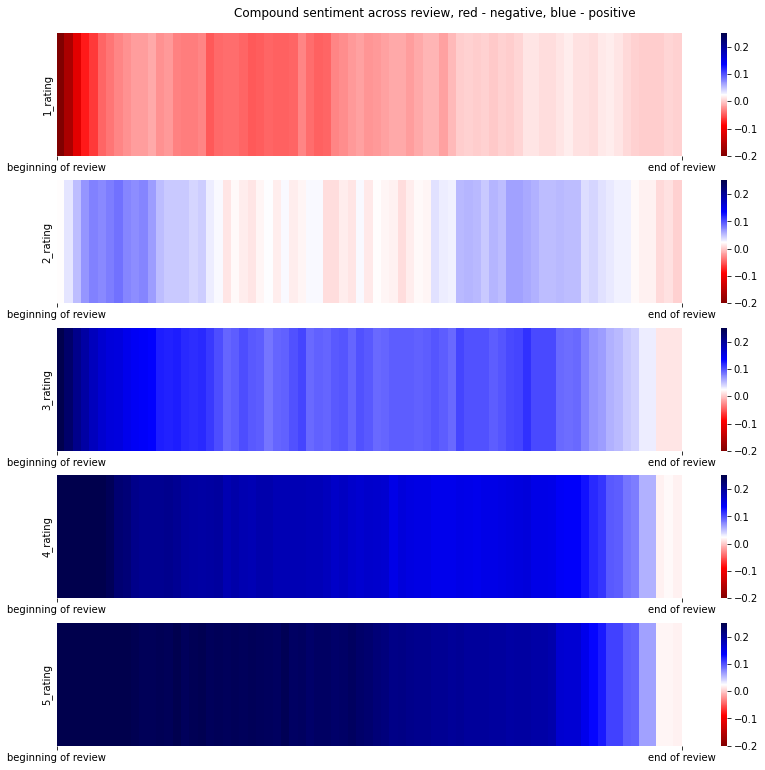

In [154]:
import seaborn as sns

def plot_sentiment(df, column_name, ratng, **kwargs):
    x = np.array(list(df.loc[df['Rating'] == ratng, column_name].values))
    x = x.mean(axis=0)[..., np.newaxis].T
    sns.heatmap(x, **kwargs)
    
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Compound sentiment across review, red - negative, blue - positive')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_compound', i+1, cmap='seismic_r', vmin=-0.20, vmax =0.25)
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])

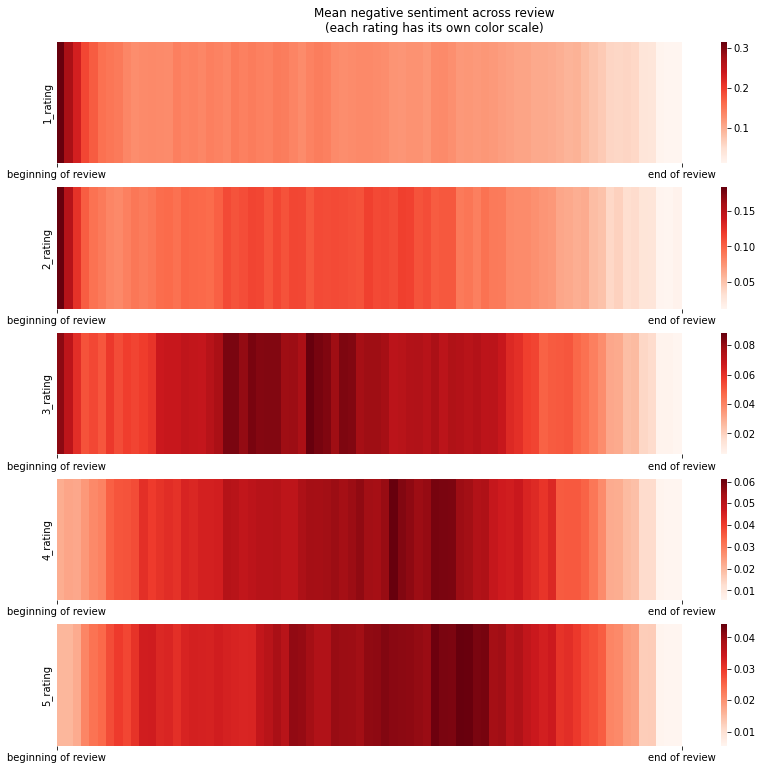

In [155]:
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Mean negative sentiment across review\n(each rating has its own color scale)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_neg', i+1, cmap='Reds')
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])

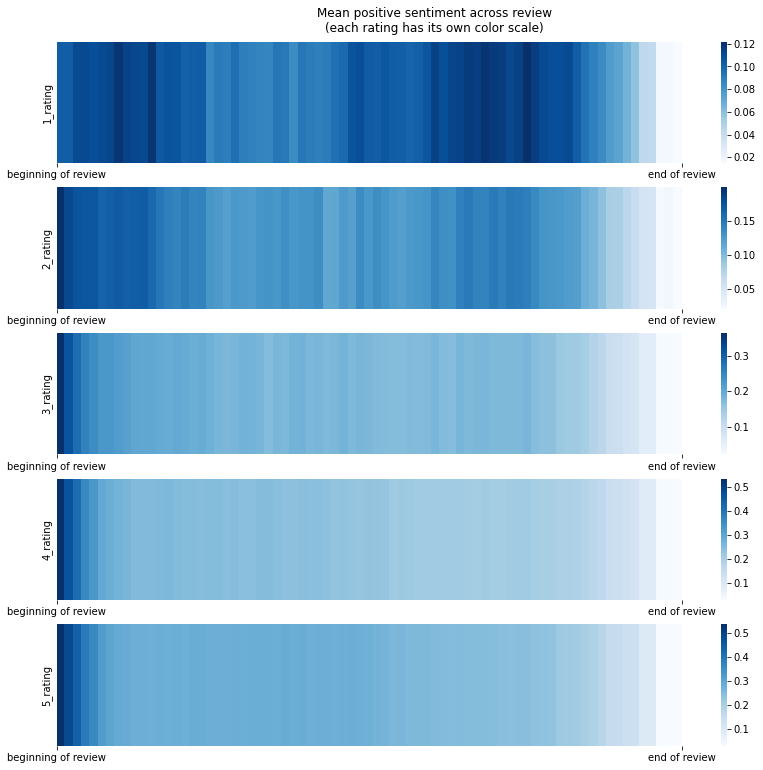

In [156]:
fig = plt.figure()
fig.set_size_inches(14,12)
fig.suptitle('Mean positive sentiment across review\n(each rating has its own color scale)')
fig.tight_layout()
fig.subplots_adjust(top=0.94)
for i in range(5):
    plt.subplot(5,1, i+1)
    plot_sentiment(df, 'sentiment_chunks_pos', i+1, cmap='Blues')
    plt.ylabel(str(i+1)+'_rating')
    plt.xticks([0, 75], ['beginning of review', 'end of review'])
    plt.yticks([])